# Microstructure characterization of battery materials based on voxelated image data: Computation of active surface area and tortuosity

## Second validation example: FCC structure

<div class="row">
  <div class="col-md-7" markdown="1">
  This validation increases the complexity of the first example by adding contact between spherical bodies while the volume fraction and surface area can still be expressed analytically as a function of the unit cell side length. This validation is well suited as
<ul>
  <li>the surface is analytically known,</li>
  <li>the example is 3D but yet simple,</li>
  <li>the surface is curved and, thus, will suffer from pixelation issues</li>
  <li>the example can be used to compute tortuosity in the solid and the pore space.</li>
</ul>
<br>
Without a defined overlap, a voxelization issue arises where for all configurations with an even number of voxels per cube length the spheres are touching at voxel edges while for all odd configurations the spheres are fully connected. This can be seen in the front view of the cube:
  </div>
  <div class="col-md-5" markdown="1">
  <img src="data-paper/fcc-study/fcc_solid_3D.png" alt="Image 1" width="220" />
  </div>
</div>
<br>

<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/fcc-study/fcc_10_pure.png" alt="2pixel" width="100" />
</p>
<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/fcc-study/fcc_11_pure.png" alt="5pixel" width="100" />
</p>
<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/fcc-study/fcc_50_pure.png" alt="10pixel" width="100" />
</p>
<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/fcc-study/fcc_51_pure.png" alt="20pixel" width="100" />
</p>
<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/fcc-study/fcc_100_pure.png" alt="50pixel" width="100" />
</p>
<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/fcc-study/fcc_101_pure.png" alt="100pixel" width="100" />
</p>


**Author**: Simon Daubner<br>
**Department**: Department of Mechanical Engineering<br>
**Institution**: Karlsruhe Institute of Technology

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import taufactor.metrics as tau
import torch

import metrics
import data
import time

We initialize the grid resolution as

In [2]:
dx = 1.0

In [3]:
fcc_results = {}
overlaps = [0.0,0.01,0.05]

for overlap in overlaps:
    resolution = [6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,50,51,100,101,200,201,300,301]

    # Initialize fields
    fcc_vol_fraction = {'theo':np.zeros(len(resolution)),
                        'num':np.zeros(len(resolution))}

    methods = ['theo', 'faces', 'marching', 'conv_marching', 'porespy', 'gradient', 'conv_gradient', 'gradient_GPU']
    area = {method: np.zeros(len(resolution)) for method in methods}
    times = {method: np.zeros(len(resolution)) for method in methods[1:]}
    time_CPU_GPU = np.zeros(len(resolution))

    connectivity_type = ['s_side', 's_edge', 's_corner', 'p_side', 'p_edge', 'p_corner']
    connectivity = {conn: np.zeros(len(resolution)) for conn in connectivity_type}
    tortuosity   = {'solid': np.zeros(len(resolution)),
                    'pore': np.zeros(len(resolution))}

    for i, pixels in enumerate(resolution):
        sharp_field = data.create_fcc_cube(pixels, overlap=overlap)
        vol, surf = data.theoretical_fcc_metrics(pixels, overlap)
        fcc_vol_fraction['theo'][i] = vol
        fcc_vol_fraction['num'][i] = metrics.volume_fraction(sharp_field, 1)

        timer=[]
        area['theo'][i] = surf
        timer.append(time.time())
        area['faces'][i] = 3*tau.surface_area(sharp_field, phases=[1]).item()
        timer.append(time.time())
        area['marching'][i] = metrics.specific_surface_area_marching(sharp_field)
        timer.append(time.time())
        phase_field = metrics.smooth_with_convolution(sharp_field)
        area['conv_marching'][i] = metrics.specific_surface_area_marching(phase_field)
        timer.append(time.time())
        area['porespy'][i]  = metrics.specific_surface_area_porespy(sharp_field)
        timer.append(time.time())
        area['gradient'][i] = metrics.specific_surface_area(sharp_field)
        timer.append(time.time())
        area['conv_gradient'][i] = metrics.specific_surface_area(sharp_field, smooth=1)
        timer.append(time.time())

        # Test GPU speed-up using pytorch
        # Separate time measurements for shifting from CPU to GPU and actual computation
        tensor = torch.tensor(sharp_field, dtype=torch.float32)
        tensor = tensor.to('cuda')
        timer.append(time.time())

        grad = torch.gradient(tensor, spacing=(dx,dx,dx))
        norm2 = grad[0].pow(2) + grad[1].pow(2) + grad[2].pow(2)
        surface_area = torch.sum(torch.sqrt(norm2))
        surface_area = surface_area.cpu().item()
        volume = np.prod(sharp_field.shape)
        area['gradient_GPU'][i] = surface_area / volume
        timer.append(time.time())

        for k, method in enumerate(methods[1:]):
            times[method][i] = np.array(timer)[k+1]-np.array(timer)[k]

        time_CPU_GPU[i] = timer[7]-timer[6]
        times['gradient_GPU'][i] = timer[8]-timer[7]

        # Compute through feature and tortuosity
        through_feature, through_fraction = metrics.extract_through_feature(sharp_field, 1, 'x')
        connectivity['s_side'][i] = through_fraction[0]
        connectivity['s_edge'][i] = through_fraction[1]
        connectivity['s_corner'][i] = through_fraction[2]

        if through_fraction[0]>0.0:
            res = metrics.tortuosity(through_feature[0], run_on='cuda')
            if res<1000: tortuosity['solid'][i] = res

        through_feature, through_fraction = metrics.extract_through_feature(sharp_field, 0, 'x')
        connectivity['p_side'][i] = through_fraction[0]
        connectivity['p_edge'][i] = through_fraction[1]
        connectivity['p_corner'][i] = through_fraction[2]

        if through_fraction[0]>0.0:
            res = metrics.tortuosity(through_feature[0], run_on='cuda')
            if res<1000: tortuosity['pore'][i] = res
        print(f"Finished FCC with {pixels}^3 voxels.")

    fcc_results[f'overlap{int(100*overlap)}'] = {'vol':fcc_vol_fraction,
                                                 'area':area,
                                                 'time':times,
                                                 'connected':connectivity,
                                                 'taufactor':tortuosity}

Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.3333334922790527                   after: 1 iterations in: 0.0074                    seconds at a rate of 0.0074 s/iter
Finished FCC with 6^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.445708990097046                   after: 101 iterations in: 0.0188                    seconds at a rate of 0.0002 s/iter
Finished FCC with 7^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Finished FCC with 8^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: inf                   after: 1 iterations in: 0.0005                    seconds at a rate of 0.0005 s/iter
converged to: inf                   after: 1 iterations in: 0.0007                    seconds at a rate of 0.0007 s/iter
Finished FCC with 9^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.6000001430511475                   after: 1 iterations in: 0.0027                    seconds at a rate of 0.0027 s/iter
Finished FCC with 10^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: inf                   after: 1 iterations in: 0.0007                    seconds at a rate of 0.0007 s/iter
converged to: inf                   after: 1 iterations in: 0.0007                    seconds at a rate of 0.0007 s/iter
Finished FCC with 11^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.555558204650879                   after: 101 iterations in: 0.0191                    seconds at a rate of 0.0002 s/iter
Finished FCC with 12^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.3880300521850586                   after: 101 iterations in: 0.0194                    seconds at a rate of 0.0002 s/iter
converged to: 4.091120719909668                   after: 101 iterations in: 0.0188                    seconds at a rate of 0.0002 s/iter
Finished FCC with 13^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.7367353439331055                   after: 101 iterations in: 0.0189                    seconds at a rate of 0.0002 s/iter
Finished FCC with 14^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.7080395221710205                   after: 101 iterations in: 0.0186                    seconds at a rate of 0.0002 s/iter
converged to: 3.4616785049438477                   after: 101 iterations in: 0.019                    seconds at a rate of 0.0002 s/iter
Finished FCC with 15^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 3.6577842235565186                   after: 101 iterations in: 0.0185                    seconds at a rate of 0.0002 s/iter
Finished FCC with 16^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: inf                   after: 1 iterations in: 0.0008                    seconds at a rate of 0.0008 s/iter
converged to: inf                   after: 1 iterations in: 0.0007                    seconds at a rate of 0.0007 s/iter
Finished FCC with 17^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 3.5371131896972656                   after: 101 iterations in: 0.019                    seconds at a rate of 0.0002 s/iter
Finished FCC with 18^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.9671061038970947                   after: 101 iterations in: 0.0182                    seconds at a rate of 0.0002 s/iter
converged to: 2.799781322479248                   after: 101 iterations in: 0.019                    seconds at a rate of 0.0002 s/iter
Finished FCC with 19^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 3.139294385910034                   after: 101 iterations in: 0.0189                    seconds at a rate of 0.0002 s/iter
Finished FCC with 20^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.8968725204467773                   after: 101 iterations in: 0.0185                    seconds at a rate of 0.0002 s/iter
converged to: 2.836069345474243                   after: 101 iterations in: 0.0185                    seconds at a rate of 0.0002 s/iter
Finished FCC with 21^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.462984085083008                   after: 101 iterations in: 0.0185                    seconds at a rate of 0.0002 s/iter
Finished FCC with 22^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 3.170393705368042                   after: 101 iterations in: 0.0184                    seconds at a rate of 0.0002 s/iter
converged to: 2.681035041809082                   after: 101 iterations in: 0.0195                    seconds at a rate of 0.0002 s/iter
Finished FCC with 23^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.596418619155884                   after: 101 iterations in: 0.0195                    seconds at a rate of 0.0002 s/iter
Finished FCC with 24^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: inf                   after: 1 iterations in: 0.0007                    seconds at a rate of 0.0007 s/iter
converged to: inf                   after: 1 iterations in: 0.0007                    seconds at a rate of 0.0007 s/iter
Finished FCC with 25^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 1.9894299507141113                   after: 301 iterations in: 0.052                    seconds at a rate of 0.0002 s/iter
Finished FCC with 50^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 4.289058208465576                   after: 201 iterations in: 0.0424                    seconds at a rate of 0.0002 s/iter
converged to: 1.9963654279708862                   after: 301 iterations in: 0.0615                    seconds at a rate of 0.0002 s/iter
Finished FCC with 51^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 1.8163295984268188                   after: 501 iterations in: 0.1517                    seconds at a rate of 0.0003 s/iter
Finished FCC with 100^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: -19.907007217407227                   after: 101 iterations in: 0.0326                    seconds at a rate of 0.0003 s/iter
converged to: 1.813828468322754                   after: 501 iterations in: 0.1571                    seconds at a rate of 0.0003 s/iter
Finished FCC with 101^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 1.7170932292938232                   after: 801 iterations in: 1.9521                    seconds at a rate of 0.0024 s/iter
Finished FCC with 200^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: -7.569298267364502                   after: 201 iterations in: 0.4814                    seconds at a rate of 0.0024 s/iter
converged to: 1.715141773223877                   after: 801 iterations in: 1.9691                    seconds at a rate of 0.0025 s/iter
Finished FCC with 201^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 1.6834146976470947                   after: 1101 iterations in: 8.7234                    seconds at a rate of 0.0079 s/iter
Finished FCC with 300^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: -204.09622192382812                   after: 201 iterations in: 1.6344                    seconds at a rate of 0.0081 s/iter
converged to: 1.686021327972412                   after: 1201 iterations in: 9.8175                    seconds at a rate of 0.0082 s/iter
Finished FCC with 301^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.3333334922790527                   after: 1 iterations in: 0.0028                    seconds at a rate of 0.0028 s/iter
Finished FCC with 6^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.445708990097046                   after: 101 iterations in: 0.0182                    seconds at a rate of 0.0002 s/iter
Finished FCC with 7^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Finished FCC with 8^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: inf                   after: 1 iterations in: 0.0006                    seconds at a rate of 0.0006 s/iter
converged to: inf                   after: 1 iterations in: 0.0006                    seconds at a rate of 0.0006 s/iter
Finished FCC with 9^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.6000001430511475                   after: 1 iterations in: 0.0028                    seconds at a rate of 0.0028 s/iter
Finished FCC with 10^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: inf                   after: 1 iterations in: 0.0006                    seconds at a rate of 0.0006 s/iter
Finished FCC with 11^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.555558204650879                   after: 101 iterations in: 0.0186                    seconds at a rate of 0.0002 s/iter
Finished FCC with 12^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 1.9655290842056274                   after: 101 iterations in: 0.0188                    seconds at a rate of 0.0002 s/iter
converged to: 5.432131290435791                   after: 101 iterations in: 0.0189                    seconds at a rate of 0.0002 s/iter
Finished FCC with 13^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.7367353439331055                   after: 101 iterations in: 0.0185                    seconds at a rate of 0.0002 s/iter
Finished FCC with 14^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.245260000228882                   after: 101 iterations in: 0.0191                    seconds at a rate of 0.0002 s/iter
converged to: 3.6835384368896484                   after: 101 iterations in: 0.0182                    seconds at a rate of 0.0002 s/iter
Finished FCC with 15^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 3.6577842235565186                   after: 101 iterations in: 0.0188                    seconds at a rate of 0.0002 s/iter
Finished FCC with 16^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: inf                   after: 1 iterations in: 0.0006                    seconds at a rate of 0.0006 s/iter
converged to: inf                   after: 1 iterations in: 0.0007                    seconds at a rate of 0.0007 s/iter
Finished FCC with 17^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 3.2445714473724365                   after: 101 iterations in: 0.019                    seconds at a rate of 0.0002 s/iter
converged to: 4.023830413818359                   after: 101 iterations in: 0.0184                    seconds at a rate of 0.0002 s/iter
Finished FCC with 18^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.254875421524048                   after: 101 iterations in: 0.02                    seconds at a rate of 0.0002 s/iter
converged to: 3.286547899246216                   after: 101 iterations in: 0.0196                    seconds at a rate of 0.0002 s/iter
Finished FCC with 19^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 3.139294385910034                   after: 101 iterations in: 0.0182                    seconds at a rate of 0.0002 s/iter
Finished FCC with 20^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.472266912460327                   after: 101 iterations in: 0.0193                    seconds at a rate of 0.0002 s/iter
converged to: 3.178074836730957                   after: 101 iterations in: 0.0194                    seconds at a rate of 0.0002 s/iter
Finished FCC with 21^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 3.966749668121338                   after: 101 iterations in: 0.0183                    seconds at a rate of 0.0002 s/iter
converged to: 3.322260856628418                   after: 101 iterations in: 0.0193                    seconds at a rate of 0.0002 s/iter
Finished FCC with 22^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.648287296295166                   after: 101 iterations in: 0.0193                    seconds at a rate of 0.0002 s/iter
converged to: 2.8805429935455322                   after: 101 iterations in: 0.0196                    seconds at a rate of 0.0002 s/iter
Finished FCC with 23^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.596418619155884                   after: 101 iterations in: 0.0191                    seconds at a rate of 0.0002 s/iter
Finished FCC with 24^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: inf                   after: 1 iterations in: 0.0007                    seconds at a rate of 0.0007 s/iter
converged to: inf                   after: 1 iterations in: 0.0007                    seconds at a rate of 0.0007 s/iter
Finished FCC with 25^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 3.683662176132202                   after: 501 iterations in: 0.0816                    seconds at a rate of 0.0002 s/iter
converged to: 2.1745846271514893                   after: 301 iterations in: 0.0513                    seconds at a rate of 0.0002 s/iter
Finished FCC with 50^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.602745532989502                   after: 201 iterations in: 0.035                    seconds at a rate of 0.0002 s/iter
converged to: 2.1191039085388184                   after: 301 iterations in: 0.052                    seconds at a rate of 0.0002 s/iter
Finished FCC with 51^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 3.864588975906372                   after: 601 iterations in: 0.178                    seconds at a rate of 0.0003 s/iter
converged to: 1.8788964748382568                   after: 501 iterations in: 0.1492                    seconds at a rate of 0.0003 s/iter
Finished FCC with 100^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.763772964477539                   after: 601 iterations in: 0.1827                    seconds at a rate of 0.0003 s/iter
converged to: 1.8804453611373901                   after: 501 iterations in: 0.1513                    seconds at a rate of 0.0003 s/iter
Finished FCC with 101^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 3.3495187759399414                   after: 1101 iterations in: 2.708                    seconds at a rate of 0.0025 s/iter
converged to: 1.7803781032562256                   after: 901 iterations in: 2.2132                    seconds at a rate of 0.0025 s/iter
Finished FCC with 200^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.897958755493164                   after: 1101 iterations in: 2.7395                    seconds at a rate of 0.0025 s/iter
converged to: 1.7786821126937866                   after: 901 iterations in: 2.2385                    seconds at a rate of 0.0025 s/iter
Finished FCC with 201^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 3.3450911045074463                   after: 1301 iterations in: 10.5171                    seconds at a rate of 0.0081 s/iter
converged to: 1.747959852218628                   after: 1101 iterations in: 8.9011                    seconds at a rate of 0.0081 s/iter
Finished FCC with 300^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.9272358417510986                   after: 1501 iterations in: 12.3149                    seconds at a rate of 0.0082 s/iter
converged to: 1.745236873626709                   after: 1101 iterations in: 9.0146                    seconds at a rate of 0.0082 s/iter
Finished FCC with 301^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.3333334922790527                   after: 1 iterations in: 0.003                    seconds at a rate of 0.003 s/iter
Finished FCC with 6^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 1.7686947584152222                   after: 101 iterations in: 0.0182                    seconds at a rate of 0.0002 s/iter
Finished FCC with 7^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Finished FCC with 8^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: inf                   after: 1 iterations in: 0.0007                    seconds at a rate of 0.0007 s/iter
Finished FCC with 9^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.0184364318847656                   after: 101 iterations in: 0.0187                    seconds at a rate of 0.0002 s/iter
Finished FCC with 10^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: inf                   after: 1 iterations in: 0.0007                    seconds at a rate of 0.0007 s/iter
Finished FCC with 11^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 1.5909489393234253                   after: 101 iterations in: 0.0188                    seconds at a rate of 0.0002 s/iter
Finished FCC with 12^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 1.9655290842056274                   after: 101 iterations in: 0.0182                    seconds at a rate of 0.0002 s/iter
converged to: 5.432131290435791                   after: 101 iterations in: 0.019                    seconds at a rate of 0.0002 s/iter
Finished FCC with 13^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.7157068252563477                   after: 101 iterations in: 0.019                    seconds at a rate of 0.0002 s/iter
Finished FCC with 14^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 1.516472339630127                   after: 101 iterations in: 0.0187                    seconds at a rate of 0.0002 s/iter
converged to: 5.934105396270752                   after: 101 iterations in: 0.0191                    seconds at a rate of 0.0002 s/iter
Finished FCC with 15^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.0886659622192383                   after: 101 iterations in: 0.0189                    seconds at a rate of 0.0002 s/iter
Finished FCC with 16^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: inf                   after: 1 iterations in: 0.0007                    seconds at a rate of 0.0007 s/iter
converged to: inf                   after: 1 iterations in: 0.0007                    seconds at a rate of 0.0007 s/iter
Finished FCC with 17^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 3.2445714473724365                   after: 101 iterations in: 0.0193                    seconds at a rate of 0.0002 s/iter
converged to: 4.023830413818359                   after: 101 iterations in: 0.0182                    seconds at a rate of 0.0002 s/iter
Finished FCC with 18^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 1.5620477199554443                   after: 101 iterations in: 0.0195                    seconds at a rate of 0.0002 s/iter
converged to: 4.737661361694336                   after: 101 iterations in: 0.0184                    seconds at a rate of 0.0002 s/iter
Finished FCC with 19^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.4821486473083496                   after: 101 iterations in: 0.0189                    seconds at a rate of 0.0002 s/iter
converged to: 4.15861701965332                   after: 101 iterations in: 0.0191                    seconds at a rate of 0.0002 s/iter
Finished FCC with 20^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 1.6776565313339233                   after: 101 iterations in: 0.0189                    seconds at a rate of 0.0002 s/iter
converged to: 4.009392738342285                   after: 101 iterations in: 0.0192                    seconds at a rate of 0.0002 s/iter
Finished FCC with 21^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 1.8637689352035522                   after: 101 iterations in: 0.02                    seconds at a rate of 0.0002 s/iter
converged to: 4.926626205444336                   after: 101 iterations in: 0.0184                    seconds at a rate of 0.0002 s/iter
Finished FCC with 22^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 1.6291087865829468                   after: 101 iterations in: 0.019                    seconds at a rate of 0.0002 s/iter
converged to: 3.5908303260803223                   after: 201 iterations in: 0.0361                    seconds at a rate of 0.0002 s/iter
Finished FCC with 23^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.006467819213867                   after: 101 iterations in: 0.0186                    seconds at a rate of 0.0002 s/iter
converged to: 4.72015905380249                   after: 301 iterations in: 0.0497                    seconds at a rate of 0.0002 s/iter
Finished FCC with 24^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: inf                   after: 1 iterations in: 0.0008                    seconds at a rate of 0.0008 s/iter
converged to: inf                   after: 1 iterations in: 0.0006                    seconds at a rate of 0.0006 s/iter
Finished FCC with 25^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 1.802089810371399                   after: 301 iterations in: 0.0509                    seconds at a rate of 0.0002 s/iter
converged to: 2.477841854095459                   after: 401 iterations in: 0.0675                    seconds at a rate of 0.0002 s/iter
Finished FCC with 50^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 1.641403317451477                   after: 301 iterations in: 0.051                    seconds at a rate of 0.0002 s/iter
converged to: 2.466700315475464                   after: 401 iterations in: 0.0685                    seconds at a rate of 0.0002 s/iter
Finished FCC with 51^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 1.7095391750335693                   after: 401 iterations in: 0.1214                    seconds at a rate of 0.0003 s/iter
converged to: 2.1845216751098633                   after: 601 iterations in: 0.1786                    seconds at a rate of 0.0003 s/iter
Finished FCC with 100^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 1.6228619813919067                   after: 401 iterations in: 0.1246                    seconds at a rate of 0.0003 s/iter
converged to: 2.1638917922973633                   after: 601 iterations in: 0.1832                    seconds at a rate of 0.0003 s/iter
Finished FCC with 101^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 1.7048239707946777                   after: 701 iterations in: 1.7226                    seconds at a rate of 0.0025 s/iter
converged to: 2.032750129699707                   after: 1001 iterations in: 2.47                    seconds at a rate of 0.0025 s/iter
Finished FCC with 200^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 1.6540603637695312                   after: 701 iterations in: 1.7437                    seconds at a rate of 0.0025 s/iter
converged to: 2.0306999683380127                   after: 1001 iterations in: 2.4909                    seconds at a rate of 0.0025 s/iter
Finished FCC with 201^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 1.6803765296936035                   after: 1101 iterations in: 8.0424                    seconds at a rate of 0.0073 s/iter
converged to: 1.9878488779067993                   after: 1301 iterations in: 8.172                    seconds at a rate of 0.0063 s/iter
Finished FCC with 300^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 1.6513477563858032                   after: 1101 iterations in: 6.9623                    seconds at a rate of 0.0063 s/iter
converged to: 1.9883733987808228                   after: 1301 iterations in: 8.2637                    seconds at a rate of 0.0064 s/iter
Finished FCC with 301^3 voxels.


### Plotting
Plot the results based on following color and line style

In [4]:
colors = ['black', 'red', 'blue', 'purple', 'orange', 'lime', 'green', 'black', 'orange']
line_styles = ['-', '-', '-.', ':', '--', '-', '-.', ':']

Plot relative volume error

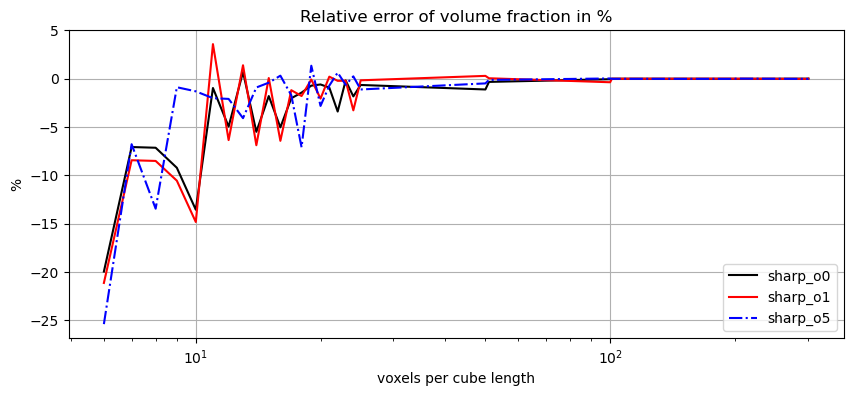

In [5]:
fig, ax = plt.subplots(figsize=(10, 4))
for i, o in enumerate(overlaps):
    ax.semilogx(resolution, (fcc_results[f'overlap{int(100*o)}']['vol']['num']-fcc_results[f'overlap{int(100*o)}']['vol']['theo'])/fcc_results[f'overlap{int(100*o)}']['vol']['theo']*100, label=f'sharp_o{int(100*o)}', color=colors[i], linestyle=line_styles[i])

ax.set_xlabel('voxels per cube length')
ax.set_ylabel('%')
ax.set_title('Relative error of volume fraction in %')
ax.legend()
ax.grid()
plt.show()

Relative error of surface area computation

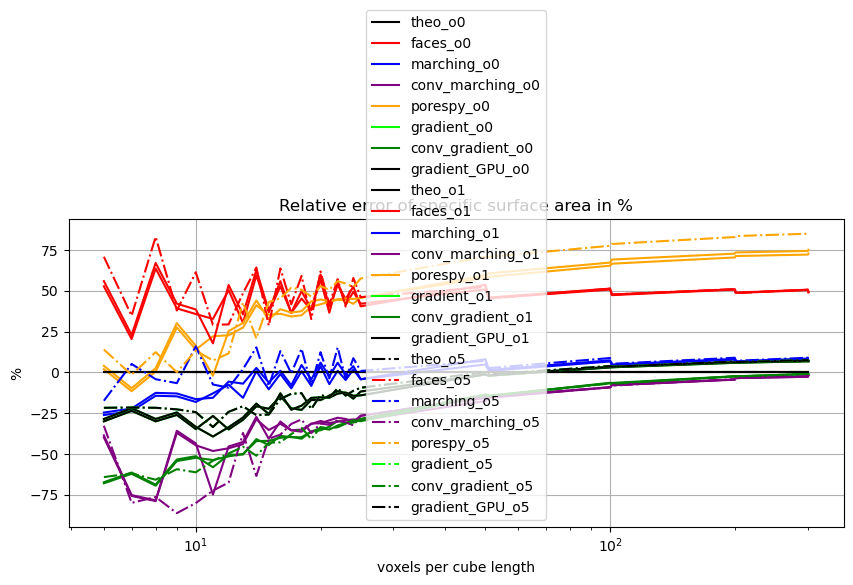

In [6]:
fig, ax = plt.subplots(figsize=(10, 4))
for i, o in enumerate(overlaps):
    for j, method in enumerate(methods):
        rel_error = (fcc_results[f'overlap{int(100*o)}']['area'][method]-fcc_results[f'overlap{int(100*o)}']['area']['theo'])/fcc_results[f'overlap{int(100*o)}']['area']['theo']*100
        ax.semilogx(resolution, rel_error, label=method+f'_o{int(100*o)}', color=colors[j], linestyle=line_styles[i])

ax.set_xlabel('voxels per cube length')
ax.set_ylabel('%')
ax.set_title('Relative error of specific surface area in %')
ax.legend()
ax.grid()

plt.show()

And, last but not least, the computation times

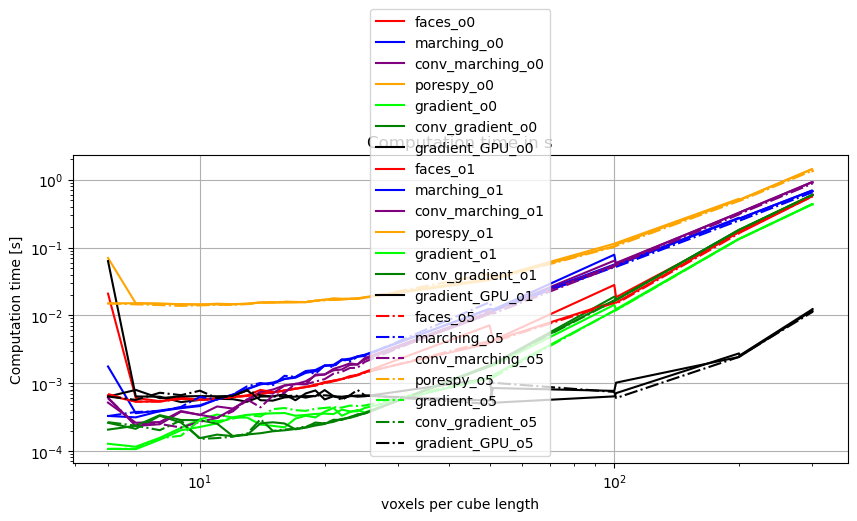

In [7]:
fig, ax = plt.subplots(figsize=(10, 4))
for i, o in enumerate(overlaps):
    for j, method in enumerate(methods[1:]):
        ax.loglog(resolution, fcc_results[f'overlap{int(100*o)}']['time'][method], label=method+f'_o{int(100*o)}', color=colors[j+1], linestyle=line_styles[i])

ax.set_xlabel('voxels per cube length')
ax.set_ylabel('Computation time [s]')
ax.set_title('Computation time in s')
ax.legend()
ax.grid()

plt.show()

### Save results to text file
Define a file name and write results dictionary as text table

In [8]:
for o in overlaps:
    file_name = f"fcc_overlap{int(100*o)}.txt"
    output = {'pixels':resolution}
    buffer = fcc_results[f'overlap{int(100*o)}']
    for key,s in buffer['vol'].items():
        header = 'vol_'+key
        output[header] = s
    for key,s in buffer['area'].items():
        header = 'a_'+key
        output[header] = s
    for key,s in buffer['time'].items():
        header = 't_'+key
        output[header] = s
    for key,s in buffer['connected'].items():
        header = 'con_'+key
        output[header] = s
    for key,s in buffer['taufactor'].items():
        header = 'tau_'+key
        output[header] = s

    data.write_dict_to_txt(output, file_name)
    print(f"Data written to {file_name}.")

Data written to fcc_overlap0.txt.
Data written to fcc_overlap1.txt.
Data written to fcc_overlap5.txt.
